# Compiled Code


In [42]:
import pandas as pd
pd.options.display.float_format = '{:,.2f}'.format
import numpy as np
import matplotlib.pyplot as plt
import os
os.chdir('/Users/acannon/Dropbox')
import seaborn as sns
sns.set_theme()
sns.set_palette('colorblind')
import warnings
warnings.filterwarnings('ignore')
from sklearn.preprocessing import StandardScaler 

## Pillar 1

## Pillar 2 - Retail Sentiment

Creating the data points for the google trends data. I standardise the data in STATA, and conduct the PCA to get the rotations.
This is hard coded, and i do not know how to save the rotations as a string or something (need to fix)

In [43]:

std = pd.read_excel('diss_data/std_gt.xlsx')
std_rot = [-0.0268,0.4361,0.2970,0.4448,0.1754,0.0226,-0.0843,-0.1768,-0.3240,0.0958,0.2119,0.1849,0.1853,0.2209,0.0963,0.1309,0.0688,-0.2044,-0.2247,-0.1791,0.1469]
var = ["Benefits","Indeed", "Linkedin", "SkyScanner" ,"Emirates" ,"Holiday" ,"Film" ,"DIY", "Gifts" ,"Clothes" ,"Jobs" ,"Merc" ,"Toyota" ,"Resort" ,"RyanAir" ,"Museums" ,"McD", "Gucci", "LV", "Zara", "fm"]

std_new = std.filter(regex= "std")

# changing the variable names from the names created in STATA to match the variable names in the list var
for col in std_new.columns:
    if col.startswith('std_resid_'):
        new_col_name = col.split('_')[2]  # Extract the variable name
        std_new.rename(columns={col: new_col_name}, inplace=True)


In [44]:
std_w = pd.DataFrame()
for i in range(0,len(var)):
    std_w[var[i]] = std_new[var[i]]*std_rot[i]

<AxesSubplot:ylabel='trends'>

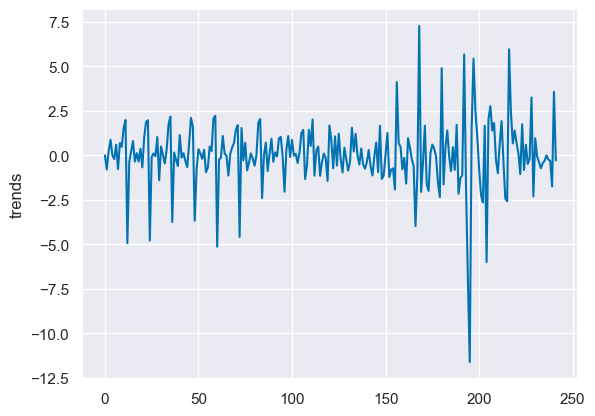

In [45]:
std_w['trends'] = std_w.sum(axis = 1)
sns.lineplot(std_w['trends'])

## Pillar 3 - LTP


<AxesSubplot:ylabel='land_pct'>

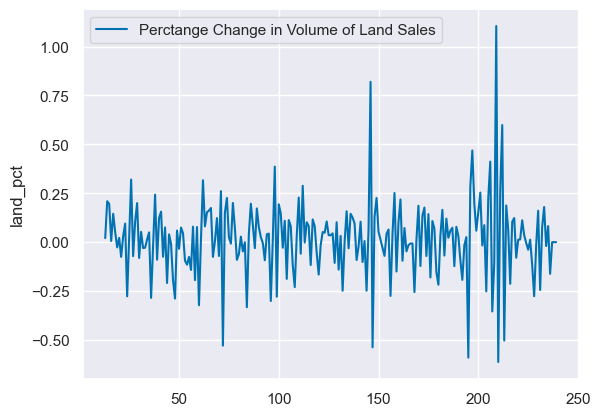

In [46]:
indicators = pd.read_excel('diss_data/more.xlsx')

# getting the long-term purchase variables from the indicator dataset
ltp = indicators[['period', 'land', 'car']]

# making them numeric because they are strings atm
ltp['car'] = pd.to_numeric(ltp['car'], errors = 'coerce')
ltp['land'] = pd.to_numeric(ltp['land'], errors = 'coerce')

# calculate percentage change
ltp['car_pct'] = ltp['car'].pct_change()
ltp['land_pct'] = ltp['land'].pct_change()

sns.lineplot(ltp['land_pct'], label = 'Perctange Change in Volume of Land Sales')

# Pillar 4

<AxesSubplot:ylabel='spread'>

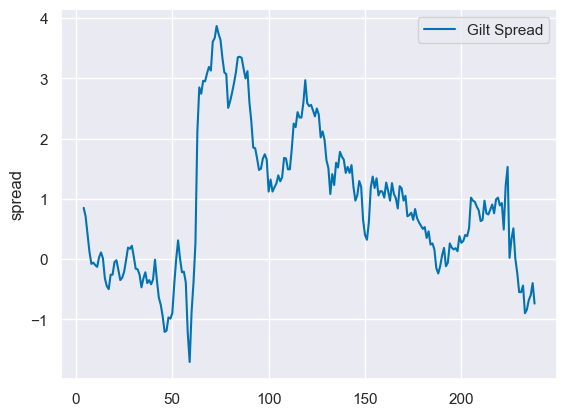

In [47]:
spread = indicators[['Y10', 'month2']]
spread['Y10'] = pd.to_numeric(spread['Y10'], errors= 'coerce')
spread['spread'] = spread['Y10'] - spread['month2']
spread['period'] = indicators['period']

sns.lineplot(spread['spread'], label = 'Gilt Spread')

In [48]:
p4 = spread[['period','spread']]

p4['indicator4'] = p4['spread']

# Pillar 5

<AxesSubplot:>

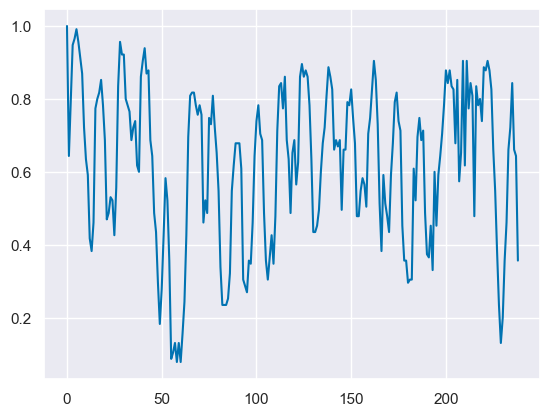

In [49]:
df_hp = pd.read_excel('diss_data/clean_hp.xlsx')
pdummy = df_hp.filter(regex = "Ip$")

pdummy.head()

diff_index = pdummy.mean(axis = 1)
diff_index.plot.line(x = df_hp['period'])

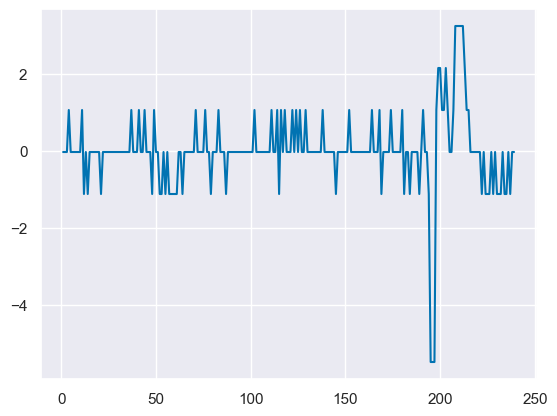

In [50]:
p5 = pd.DataFrame()
p5['vacancy'] = indicators[['all_vacancies']]
p5['vac_diff'] = p5['vacancy'].diff()
p5['period'] = indicators['period']

scaler = StandardScaler()
std_p5 = pd.DataFrame(scaler.fit_transform(p5[['vacancy','vac_diff']]), columns = [['vacancy','vac_diff']])

plt.plot(std_p5['vac_diff'])

<AxesSubplot:ylabel='indicator5'>

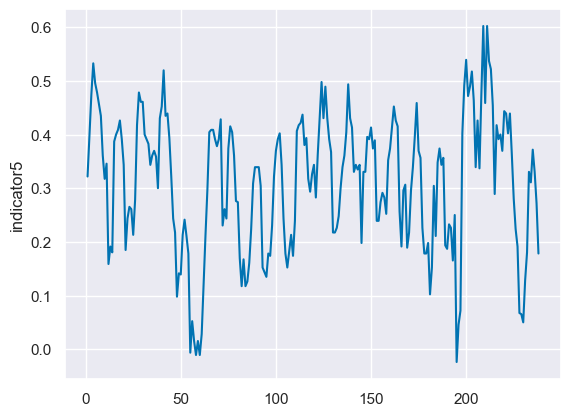

In [51]:
p5['diff_index'] = diff_index

p5['indicator5'] = 0.5 * p5['diff_index'] + 0.5 * p5['vac_diff']

sns.lineplot(p5['indicator5'])

## Constructing the Sentiment Index

In [129]:
frames = [p4,p5]
SI = p4.merge(p5, how = 'left', on = 'period')

In [134]:
SI.head()
SI = SI.filter(regex = r'indicator')
SI['period'] = p5['period'] 
SI['indicator2'] = std_w['trends']

In [137]:
SI['final'] = SI[['indicator2','indicator4','indicator5']].mean(1, skipna=True)

<AxesSubplot:>

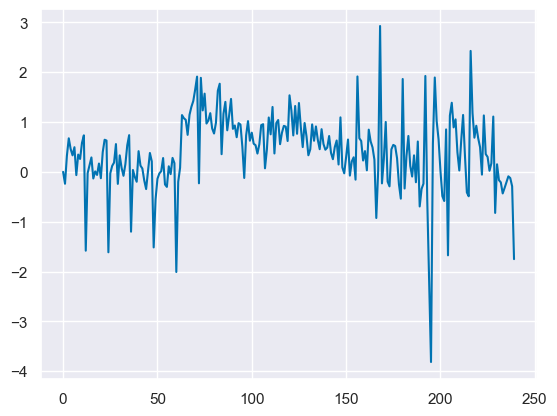

In [138]:
SI['final'].plot()

<AxesSubplot:>

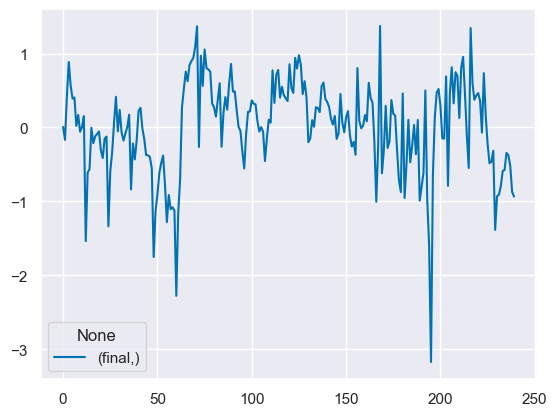

In [159]:

std_SI = pd.DataFrame(scaler.fit_transform(SI[['indicator2','indicator4','indicator5']]), columns = [['indicator2','indicator4','indicator5']])
std_SI['final'] = std_SI[['indicator2','indicator4','indicator5']].mean(1, skipna=True)
std_SI['period'] = SI['period']


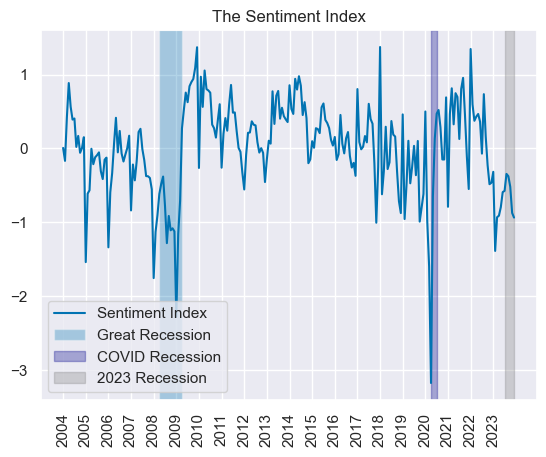

In [181]:
january_indices = [i for i in range(len(std_SI)) if std_SI.index[i] % 12 == 0]

plt.plot(std_SI['final'], label = 'Sentiment Index')
plt.xticks(january_indices, labels = [2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022, 2023], rotation = 'vertical')
plt.title('The Sentiment Index')


# trying to add grey area for recessions
# index 0 is 2004 - 01
# 2008-01 == 48
# 2008-04 == 51
# 2008 Q2 (51) - 2009 Q2 (63)
# 2020 Q1 (195) - Q2 (198)
# 2023 Q3 (234) - Q4 (239)
plt.axvspan(51, 63, alpha = 0.3, label = 'Great Recession')
plt.axvspan(195, 198, alpha = 0.3, label = 'COVID Recession', color = 'darkblue')
plt.axvspan(234, 239, alpha = 0.3, label = '2023 Recession', color = 'grey')
plt.legend(loc = 'lower left')
plt.show()

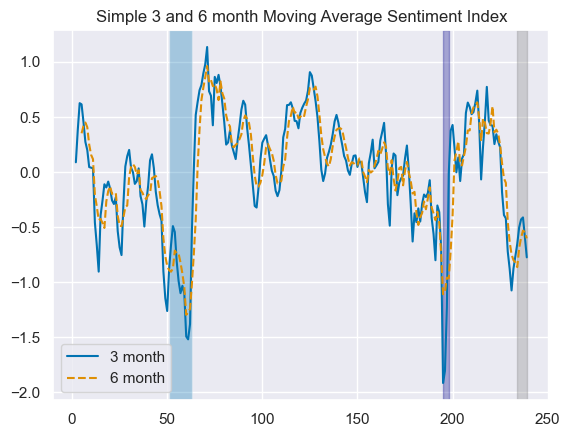

In [203]:

sma3 = std_SI['final'].rolling(3).mean()
sma6 = std_SI['final'].rolling(6).mean()
plt.plot(sma3, label = '3 month')
plt.plot(sma6, label = '6 month', linestyle = 'dashed')
plt.axvspan(51, 63, alpha = 0.3)
plt.axvspan(195, 198, alpha = 0.3, color = 'darkblue')
plt.axvspan(234, 239, alpha = 0.3, color = 'grey')
plt.title('Simple 3 and 6 month Moving Average Sentiment Index')
plt.legend(loc = 'lower left')

Text(0.5, 1.0, '$\\alpha = 0.05$')

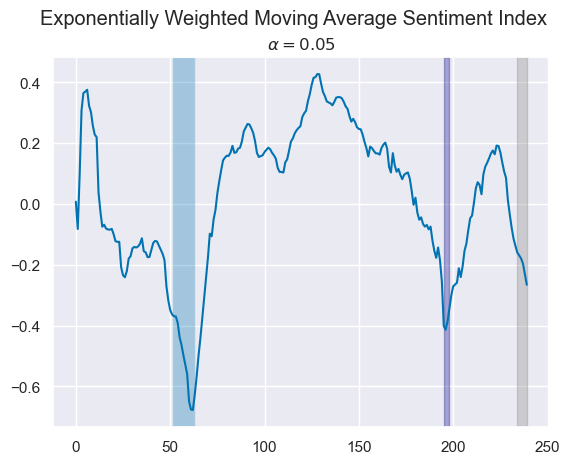

In [198]:
ema = std_SI['final'].ewm(alpha = 0.05).mean()
plt.plot(ema)
plt.axvspan(51, 63, alpha = 0.3, label = 'Great Recession')
plt.axvspan(195, 198, alpha = 0.3, label = 'COVID Recession', color = 'darkblue')
plt.axvspan(234, 239, alpha = 0.3, label = '2023 Recession', color = 'grey')
plt.suptitle('Exponentially Weighted Moving Average Sentiment Index')
plt.title(r'$\alpha = 0.05$')


In [162]:
std_SI[['indicator2', 'indicator4', 'indicator5']].describe()

,indicator2,indicator4,indicator5
count,240.00,235.00,238.00
mean,0.00,0.00,0.00
std,1.00,1.00,1.00
min,-6.24,-2.22,-2.65
25%,-0.39,-0.79,-0.74
50%,0.01,-0.08,0.22
75%,0.47,0.58,0.74
max,3.92,2.48,2.31
